# CANDELA demonstration

The **CANDELA (COBRA ANomaly DEtection Library)** was designed for various application areas. The toolbox is currently focused on datasets <br/>
consisting of trajectories of moving subjects/objects, however, it allows the analysis of the time series relating to many different fields of application,<br/>
like the human brain, the economy, the climate, or other complex systems. The toolbox has a modular structure that allows the extension of the functionality. <br/>
The outlier detection techniques based on machine learning, which are included in the current version of the software, <br/>
are based on the Scikit-learn library (Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011).

This notebook demonstrates the toolkit application to the anomaly detection on a set of trajectories and to the human brain intracranial EEG data.

# Crowd data example

This showcase uses crowd data as a first example. Those are trajectories of people moving through the square in the center of the city. <br/>
Video recordings were preprocessed, and trajectories per person were detected. Those data include track_id (personal identification), x,y coordinates, frame_id (time).

## Load sample data

In [1]:
# Import necessary libraries and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import src.candela.functions as af
import src.candela.particles2d as a2
import src.candela.plotting as ap

In [2]:
# Load the example data
fpathIn = 'tests/integration/fixtures/'
filename = os.path.join(fpathIn, 'sample_traces.csv')
df = pd.read_csv(filename)

# Define constants specific to particular video and analysis
SPATIAL_SCALE = 43.3/37         # rescaling constant to have spatial coordinate in meters
FRAMES_FREQUENCY = 10           # amoung of frames per second
START_TIME = 1568379600.113061  # video start time
KMH_FLAG = True                 # boolean flag, defining the units for velocity: kh/h if TRUE, m/sec if FALSE (default)

CANDELA includes the preprocessing function that computes features useful for the anomaly detection. 

The following function preprocesses the tracks of particles in a 2-D space for further analysis and anomaly detection. <br/>
The input DataFrame should contain at least two columns:
   - x, y: coordinates of the particle at the given time.

Additionally two more columns can be considered:
   - frame_id: time point id of the coordinates, useful when not all times are recorded and interpolation is needed;
   - track_id: particle id of the coordinates, when more than one track is available.

In [3]:
id_example = 134984 
track = a2.preprocess(df[df.track_id == id_example], filterVel=False, fps=FRAMES_FREQUENCY, kmh=KMH_FLAG, scale=SPATIAL_SCALE, startTime=START_TIME)

Basic statistics and visualisation:

Track_id: 134984.0.
Total track length: 35.5 s
Min x: 4.468, Max x: 16.43
Min y: 6.133, Max y: 8.725
Sepeed: Max 20.15, Min 0.0, Mean 2.979+/-3.473


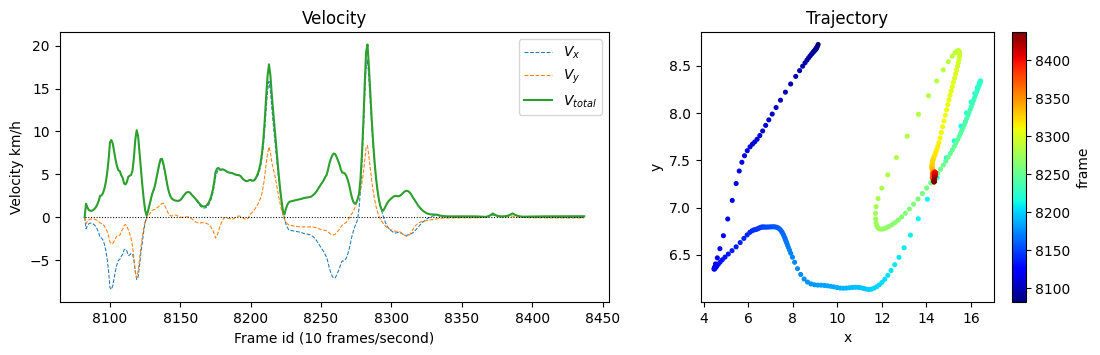

In [4]:
a2.basic_stats(track)

fig, axs = plt.subplots(1, 2, figsize=(13, 3.5), width_ratios=[0.6, 0.4])

ax = ap.show_trajectories2D('x', 'y', 'frame_id', data=track, cbarName="frame",
                            ax=axs[1], forceCbar=True, equalAspectRatio=False) [1]
ax.set_title('Trajectory')
ax = ap.plot_features('frame_id', ['vx', 'vy', 'vtot'], featureLabels=[r'$V_{x}$', r'$V_{y}$', r'$V_{total}$'], featureKW=[
                      {"linewidth": .75, "linestyle": 'dashed'}, {"linewidth": .75, "linestyle": 'dashed'}, {}], data=track, ax=axs[0])[1]

ax.plot(track['frame_id'], np.zeros_like(track['vy']), ':k', linewidth=.75)
ax.set_title('Velocity')
ax.set_xlabel("Frame id (10 frames/second)")
ax.set_ylabel("Velocity km/h")
plt.show()

## Single feature analysis: velocity

On a level of single feature, the simple threshold can be informative. For instance, speed higher than 7km/h is a potential outlier. <br/>

More advanced methods also can be used in this case. In the current version of the software, the next methods are available: 
* _Threshold-based methods_ (Simple threshold and double threshold)
* _Tukey's method_ (Tukey, John W (1977). "Exploratory Data Analysis". Addison-Wesley Publishing Company).
* _Isolation Forest_ (Liu, Fei Tony, Ting, Kai Ming and Zhou, Zhi-Hua. “Isolation forest.” Data Mining, 2008. ICDM’08. Eighth IEEE International Conference on).
* _Local Outlier Factor_ (Breunig, Kriegel, Ng, and Sander (2000) LOF: identifying density-based local outliers. Proc. ACM SIGMOD) 
* _Robust covariance_ (Rousseeuw, P.J., Van Driessen, K. “A fast algorithm for the minimum covariance determinant estimator” Technometrics 41(3), 212 (1999))
* _One-class Support Vector Machine_ (Estimating the support of a high-dimensional distribution Schölkopf, Bernhard, et al. Neural computation 13.7 (2001): 1443-1471.)


The plotting function takes as an input the time series and indices of the outliers and produces the plot where continuous subsequences of outliers are marked by the red line. <br/>
Flag _showPoints_ when put to True, allows marking the start and end of such subsequences, which might be very useful for marking the isolated outlier points.<br/>
The following cell demonstrates several methods and their visualization:

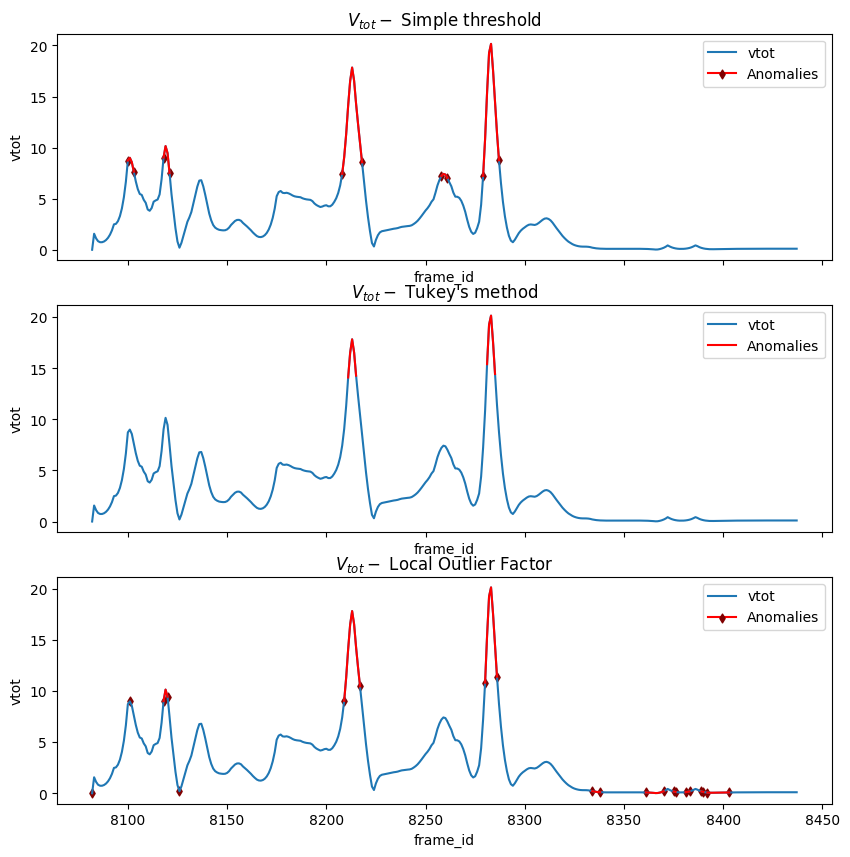

In [5]:
outliers_velocity_threshold = af.simple_threshold(track.vtot, threshold = 7)
outliers_velocity_tukeys = af.tukeys_method(track.vtot, anomalyScale = 2)
outliers_velocity_LOF = af.local_outlier_factor(track.vtot)

fig, axs = plt.subplots(3, 1, figsize = (10,10), sharex=True)

fig, ax = ap.plot_features('frame_id','vtot',outliers=outliers_velocity_threshold, outlierLabels="Anomalies", data=track, showPoints=True, ax=axs[0])
ax.set_title(r"$V_{tot} -$ Simple threshold")
fig, ax = ap.plot_features('frame_id','vtot',outliers=outliers_velocity_tukeys, outlierLabels="Anomalies", data=track, ax=axs[1])
ax.set_title(r"$V_{tot} -$ Tukey's method")
fig, ax = ap.plot_features('frame_id','vtot',outliers=outliers_velocity_LOF, outlierLabels="Anomalies", data=track, showPoints=True, ax=axs[2])
ax.set_title(r"$V_{tot} -$ Local Outlier Factor")

plt.show()

## Single feature analysis: rapid angle changes

Another type of anomalies,  as rapid trajectory changes, also can be detected. Appropriate feature for this type of anomalies might be the angle and it's derivatives.

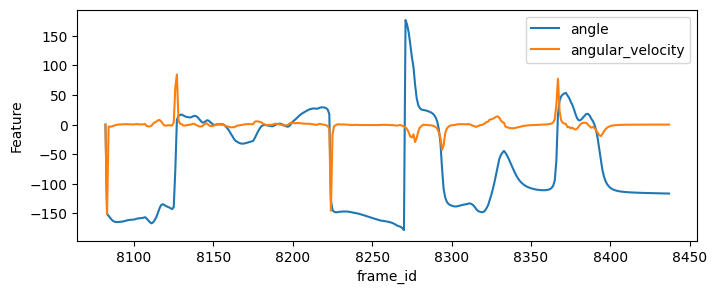

In [6]:
fig, ax = ap.plot_features('frame_id',["angle", "angular_velocity"], data=track)
plt.show()

Detection of the potential anomalies:

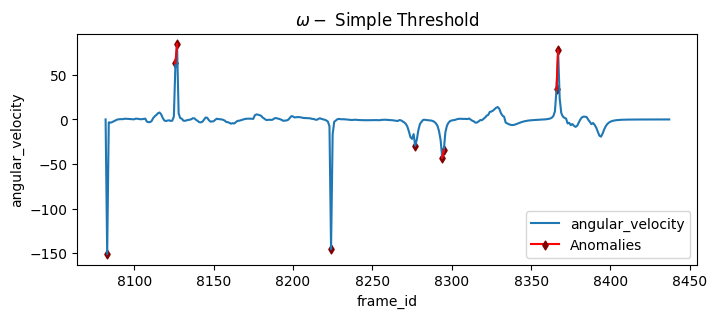

In [7]:
outliers_trajectory_threshold = af.simple_threshold(track.angular_velocity, threshold=25, absolute=True)

fig, ax = ap.plot_features('frame_id','angular_velocity',outliers=outliers_trajectory_threshold, outlierLabels="Anomalies", data=track, showPoints=True)
ax.set_title(r"$\omega -$ Simple Threshold")
plt.show()

The following graph shows the trajectory, where color corresponds to the velocity (km/h), where velocity and angular anomalies are marked.<br/>
Red stars (angular/trajectory anomalies) correspond to the rapid angle change, which is unexpected for the standard behavior of people on a square. <br/>
Black diamonds mark all the points with a speed higher than 7km/h, which is also suspicious for a pedestrian.

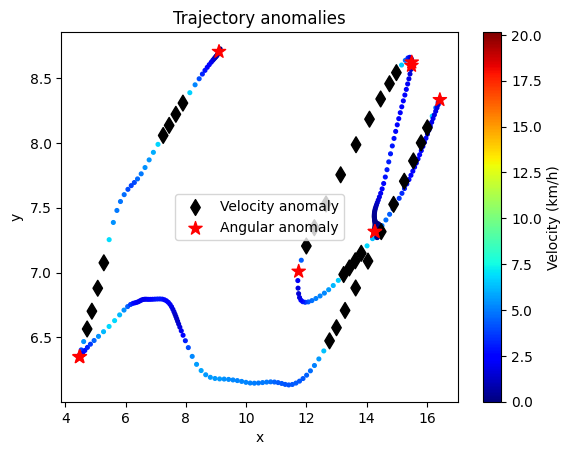

In [8]:
fig=ap.show_trajectories2D('x','y','vtot',outliers=[outliers_velocity_threshold, outliers_trajectory_threshold],
 data=track, outlier_names=["Velocity anomaly","Angular anomaly"], cbarName = "Velocity (km/h)")
plt.title("Trajectory anomalies")
plt.show()

## State detection

The state detection can be also estimated from the data, using the _double_thresohld_ function. The function allows the detection of two types of anomalies.<br/>
On the following chart, the orange line marks the segment of moving, green parts are noise, where the velocity is nonzero, but it's not classified as moving.<br/>
Note that moving is detected also where the speed drops to a low value, but for a short moment.

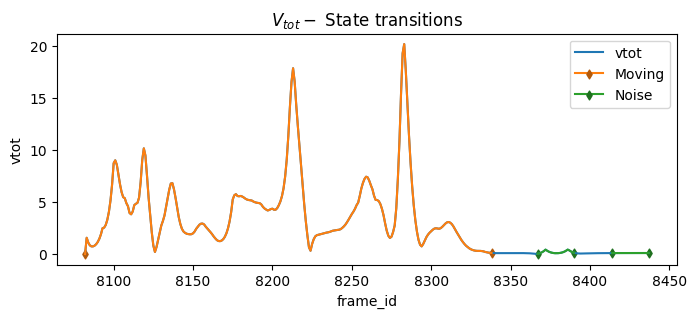

In [14]:
anom, noise = af.double_threshold(track.vtot, 150, returnNoise=True, maxSpacing=10, threshold=.10)
fig, ax = ap.plot_features('frame_id','vtot',outliers=[anom, noise], outlierLabels=["Moving", "Noise"], data=track, showPoints=True)

ax.set_title(r"$V_{tot} -$ State transitions")
plt.show()

## Multidimensional complex feature

Further, we propose the methodology for analysis based on a wider set of the trajectories. In a mowing window, multidimensional feature can be computed, and used for anomalies detection. 

We define the set of features from the dataFrame for further multivariate analysis as _basic_features_. Average and maximal values will be computed in a sliding window for the analysis. <br/>
The list of default features is also included in scatter_cluster object, that can be accessed and/or modified. In _advanced_features_ additional functions,  <br/>
that should be applied to selected features, are defined. For example, we are interested in rescaled average *absolute value* of angular velocity, otherwise the mean will be close to 0.

In [10]:
basic_features = ['residual', 'vtot', 'atot', 'angular_velocity']
advanced_features = [("angular_velocity", "mean", lambda x: np.mean(np.abs(x))/180), ("angular_velocity", "max", lambda x: np.max(np.abs(x))/180)]

When working with a dataset of trajectories, please fill the path to your data and uncomment the following cell:

In [11]:
# from tqdm import tqdm
# fpath_to_your_file = '...' # add path to your data
# df = pd.read_csv(fpath_to_your_file)

# # First we select and preprocess all the traces or the subset of them. For example, those with at least 240 recorded time points:
# df_tracks = df['track_id'].value_counts()
# frequent_values = df_tracks[df_tracks >= 240].index
# df_frequent = df[df['track_id'].isin(frequent_values)]
# tqdm.pandas(desc="Preprocess")
# preprocessed_traces = df_frequent.groupby("track_id", as_index=False).progress_apply(a2.preprocess, filterVel=False)
# global_trajectory_feature = af.scatter_cluster.segment(preprocessed_traces, basic=basic_features, advanced=advanced_features)

For the purpose of this showcase, we download the precomputed global trajectory feature. Comment the cell, if the previous one used:

In [12]:
# In this case we will load the precomputed features directly from file
filename = os.path.join(fpathIn, 'features.pickle')
global_trajectory_feature = pd.read_pickle(filename)

Then we instantiate a scatter_cluster object. This will take care of segmentation of the data and of the labeling of outliers. <br/>
When instantiating a new scatter_cluster we need to provide a kernel, it is possible to use any of: IsolationForest, OneClassSVM, RobustCovariance


In [13]:
scatter_cluster_model = af.scatter_cluster("IsolationForest")

We select a list of features from the output of the segmentation and we use them to fit the model.

In [14]:
trained_model = scatter_cluster_model.fit(global_trajectory_feature, feature_list="all")

Finally we use the model to identify the outliers among all the analyzed trajectories.

In [15]:
outliers_XY_RC = (scatter_cluster_model.predict(global_trajectory_feature, returnLabels=True) == -1).astype(int)

Now we can use the model, trained on the bigger set of trajectories, to identify outliers also in other trace.
This time we use the _segment_trace_ method.

In [16]:
df_sel_prepro = a2.preprocess(df[df.track_id==134984], filterVel=False)
local_trajectory_feature = scatter_cluster_model.segment_trace(df_sel_prepro, basic=basic_features, advanced=advanced_features)
outlier_labels_sel = (scatter_cluster_model.predict(local_trajectory_feature, returnLabels=True) == -1).astype(int)

This approach allows training of the model of outlier detection on a set of trajectories, and later other data can be tested. This might be beneficial, <br/>
for example, in the case of a too-short trajectory, where usual trajectory detection is problematic. Also, this information might be used for further data analysis, <br/>
such as the identification of the most informative feature, or distribution of outliers in space and/or time.

In this example, we plot the data points, obtained from the subset of trajectories, where color determines if the point is an outlier [red] or not [blue]. <br/>
Also, the big circles mark the analyzed single trajectory (the yellow color means being an outlier).

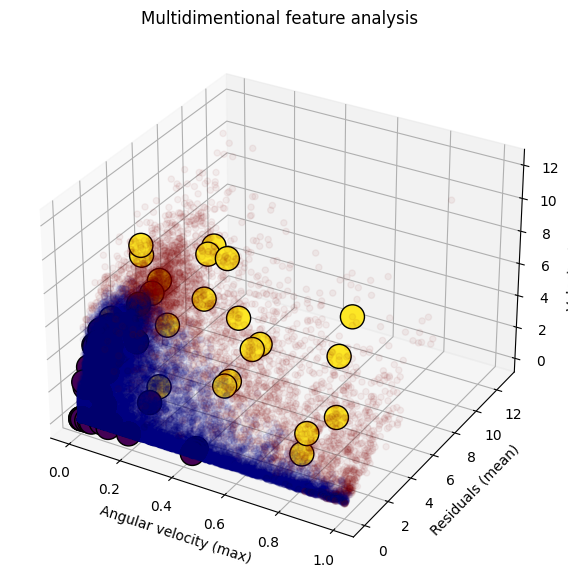

In [17]:
factor1 = 'angular_velocity_max'
factor2 = 'residual_mean'
factor3 = 'vtot_mean'

x = global_trajectory_feature[factor1] 
y = global_trajectory_feature[factor2] 
z = global_trajectory_feature[factor3]

x_sel = local_trajectory_feature[factor1]
y_sel = local_trajectory_feature[factor2]
z_sel = local_trajectory_feature[factor3]

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

ax.scatter3D(x,y,z, c = outliers_XY_RC, cmap = 'jet', alpha = 0.05)
ax.scatter3D(x_sel,y_sel,z_sel, s = 300, c = outlier_labels_sel, edgecolor='black',alpha = 1)

ax.set_xlabel('Angular velocity (max)')
ax.set_ylabel('Residuals (mean)')
ax.set_zlabel('Velocity (mean)')
ax.set_title('Multidimentional feature analysis')

plt.show()

# Brain data example

The second part of the showcase will be devoted to brain data. Despite the main functionality of the library being written for data in 2 dimensions + time, it can be useful also for other multidimensional data.

## Load iEEG data

In [18]:
from scipy.signal import convolve2d

def ma(timeSeries, window_size = 1):
    '''Moving average with Npoints'''
    if timeSeries.ndim == 1:
        window_average = np.array(pd.Series(timeSeries).ewm(window_size, min_periods=1).mean())
    else:
        window_average = convolve2d(timeSeries.T, np.ones((1, window_size)), 'valid') / window_size
        window_average = window_average.T
    return window_average

As an example of human brain data, we use the intracranial EEG recordings from The SWEC-ETHZ iEEG Database (https://iis-people.ee.ethz.ch/~ieeg/),<br/>
Short-term dataset, ID1, seizure 1, first two electrodes. As it's written in the data description, the frequency is 512Hz, and the file contains seizure and 3 minutes before and after it. 

In [19]:
from scipy.io import loadmat

# Data can be found also here: https://iis-people.ee.ethz.ch/~ieeg/BioCAS2018/dataset/ID1.zip
filename = os.path.join(fpathIn, "sample_ieeg.mat")
mat = loadmat(filename)
fs = 512
szStart = fs*3*60
szEnd = mat['EEG'].shape[0] - fs*3*60

We create the dataFrame, that as _x_ and _y_ coordinates will be used first two coordinates. <br/>
This can be also done, for example, with the two components of PCA, or ICA, or similar dimension reduction techniques. However, here we show that even single electrodes contain sufficient information.

We also subsample the smoothed data, which works as a denoising step. 

In [20]:
delta = 100

df = pd.DataFrame()
df['x'] = ma(mat['EEG'],delta)[::delta,0]
df['y'] = ma(mat['EEG'],delta)[::delta,1]

szStartSub = np.round(szStart/delta,0).astype(int)
szEndSub = np.round(szEnd/delta,0).astype(int)

seizure_label = np.zeros_like(df['x'])
seizure_label[szStartSub:szEndSub] = 1

In this case, the dataFrame consists from only one track_id, for which we apply the same preprocessing:

In [21]:
track = a2.preprocess(df, track_id=0, sequential_frames=True, filterVel=False)

Plotting the basic features shows that both velocity and coordinates themselves can be useful for seizure detection.

Track_id: 0.0.
Total track length: 2.48e+02 s
Min x: -24.8, Max x: 25.55
Min y: -16.53, Max y: 22.42
Sepeed: Max 945.1, Min 0.0, Mean 90.37+/-106.6


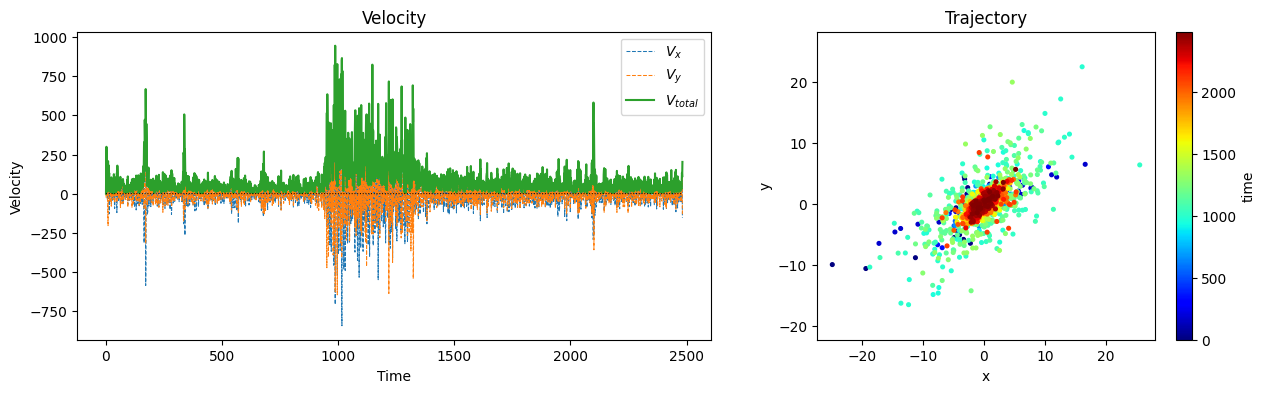

In [22]:
a2.basic_stats(track)

fig, axs = plt.subplots(1, 2, figsize=(15, 4), width_ratios=[0.6, 0.4])

ax = ap.show_trajectories2D('x', 'y', 'frame_id', data=track, cbarName="time",
                            ax=axs[1], forceCbar=True, equalAspectRatio=True) [1]
ax.set_title('Trajectory')
ax = ap.plot_features('frame_id', ['vx', 'vy', 'vtot'], featureLabels=[r'$V_{x}$', r'$V_{y}$', r'$V_{total}$'], featureKW=[
                      {"linewidth": .75, "linestyle": 'dashed'}, {"linewidth": .75, "linestyle": 'dashed'}, {}], data=track, ax=axs[0])[1]

ax.plot(track['frame_id'], np.zeros_like(track['vy']), ':k', linewidth=.75)
ax.set_title('Velocity')
ax.set_xlabel("Time")
ax.set_ylabel("Velocity")
plt.show()

## Single feature analysis

The Robust Covariance method, applied to the total velocity gives reasonable results: identifies the spikes with the higher amplitude. <br/> 
Those spikes mostly come with the seizure, but also a few before and after the seizure marks. Note that for this data those spikes are a relevant clinical marker.<br/>
Isolation Forest, applied to the same feature, gives similar, but slightly better results.

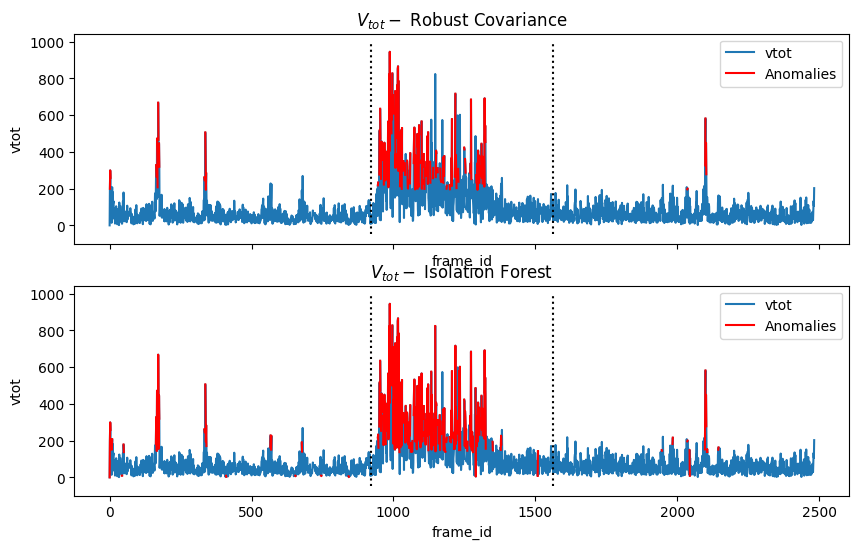

In [23]:
outliers_velocity_RC_idx = af.robust_covariance(track.vtot)
outliers_velocity_IF_idx = af.isolation_forest(track.vtot)

fig, axs = plt.subplots(2, 1, figsize = (10,6), sharex=True)

fig, ax = ap.plot_features('frame_id','vtot',outliers=outliers_velocity_RC_idx, outlierLabels="Anomalies", data=track, ax=axs[0])
ax.set_title(r"$V_{tot} -$ Robust Covariance")
ylim=plt.ylim()
plt.plot([szStartSub,szStartSub], ylim, ':k')
plt.plot([szEndSub,szEndSub], ylim, ':k')

fig, ax = ap.plot_features('frame_id','vtot',outliers=outliers_velocity_IF_idx, outlierLabels="Anomalies", data=track, ax=axs[1])
ax.set_title(r"$V_{tot} -$ Isolation Forest")
ylim=plt.ylim()
plt.plot([szStartSub,szStartSub], ylim, ':k')
plt.plot([szEndSub,szEndSub], ylim, ':k')

plt.show()

## Analysis of the coordinates (2-D)

Similarly, both outlier detection techniques can be applied to 2-D coordinates. <br/>
In the following picture, the size of the points corresponds to the mark (bigger circles for seizure, small for an interictal part). <br/>
Color corresponds to outlier detection: red points are marked as outliers, and blue ones are detected as inliers.

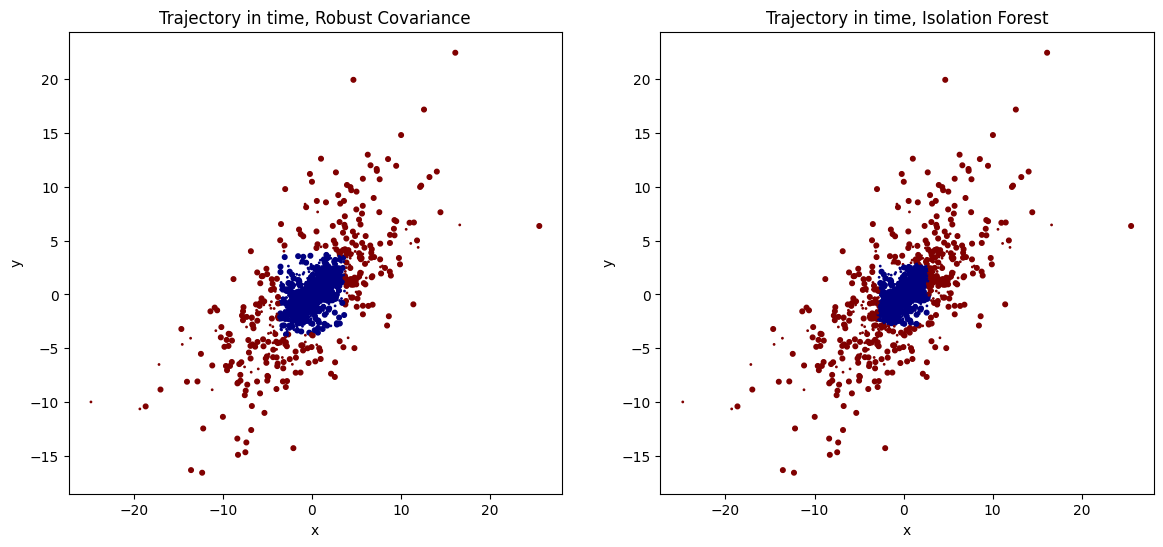

In [24]:
timeSeries = np.asarray([track['x'], track['y']]).T

outlier_labels_idx = af.robust_covariance(timeSeries)
outliers_XY_RC = np.zeros_like(timeSeries[:,0])
outliers_XY_RC[outlier_labels_idx] = 1

outlier_labels_idx = af.isolation_forest(timeSeries)
outliers_XY_IF = np.zeros_like(timeSeries[:,0])
outliers_XY_IF[outlier_labels_idx] = 1

fig, axs = plt.subplots(1, 2, figsize = (14,6))
axs[0].scatter(x = timeSeries[:,0],y = timeSeries[:,1], c = outliers_XY_RC, s = seizure_label*10 + np.ones_like(outliers_XY_RC), cmap = 'jet')
axs[0].set_title('Trajectory in time, Robust Covariance')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')

axs[1].scatter(x = timeSeries[:,0],y = timeSeries[:,1], c = outliers_XY_IF, s = seizure_label*10 + np.ones_like(outliers_XY_IF), cmap = 'jet')
axs[1].set_title('Trajectory in time, Isolation Forest')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')

plt.show()

As can be seen from the graph above, both methods give reasonable results. Note, that the results are in good correspondence with the previous ones: <br/>
points, laying outside, correspond to the high amplitude on the velocity graph. Still, there are set of points that were not marked as seizure.<br/> 
That happens because the amplitude itself is not a perfect marker of seizure. For example, the last third of this particular seizure is not different from a post-seizure interval.


## Multidimensional complex feature

The multidimensional complex feature, introduced for the crowd data, can be computed for iEEG case as well. We introduce additional feature, to show the _scatter_cluster_ usage.


In [25]:
from scipy.signal import hilbert

def envelope(signal):
    analytic_signal = hilbert(signal, axis=0)
    amplitude_envelope = np.abs(analytic_signal)
    return amplitude_envelope 

track['x_env'] = envelope(track['x'])
track['y_env'] = envelope(track['y'])
track['v_env'] = np.sqrt(track['x_env']**2 + track['y_env']**2)


The set of basic features is a subset of dataFrame column names, that we want to include in the analysis:

In [26]:
basic_features = ['residual', 'vtot', 'atot', 'v_env']
advanced_features = []

Segmenting the data and computing features:

In [27]:
global_trajectory_feature = af.scatter_cluster.segment(track, basic=basic_features, advanced=advanced_features)

Segmenting traces: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


Similarly to the previous example, we initialize the object with the outlier detection method, fit the model, and then identify outliers.

In [28]:
scatter_cluster_model = af.scatter_cluster("RobustCovariance")
trained_model = scatter_cluster_model.fit(global_trajectory_feature, feature_list="all")
outliers_XY_RC = (scatter_cluster_model.predict(global_trajectory_feature, returnLabels=True) == -1).astype(int)

3-D projection shows that Robust Covariance has several False Negatives. Similarly to 2-D case, the size of the points corresponds to the mark (bigger circles for seizure, small for an interictal part). <br/>
Color corresponds to outlier detection: red points are marked as outliers, and blue ones are detected as inliers.

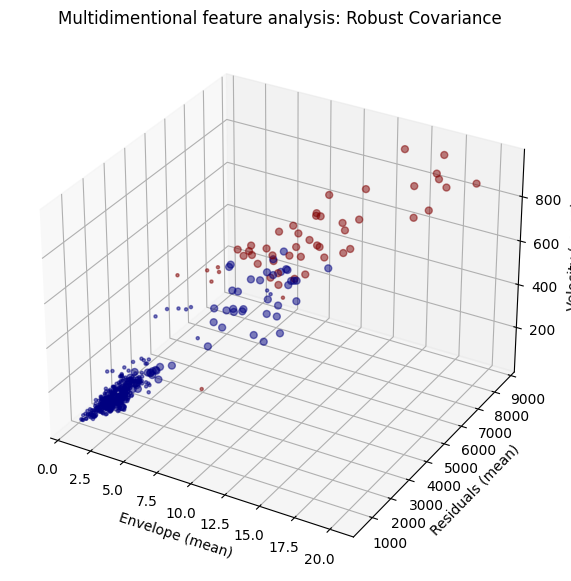

In [29]:
mwLength = 20
step = 5
seizure_label_sub = seizure_label[:-mwLength:step]

factor1 = 'v_env_mean'
factor2 = 'residual_mean'
factor3 = 'vtot_max'

x = np.asarray(global_trajectory_feature[factor1])
y = np.asarray(global_trajectory_feature[factor2])
z = np.asarray(global_trajectory_feature[factor3])

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

ax.scatter3D(x,y,z, c = outliers_XY_RC, s = seizure_label_sub*20 + np.ones_like(seizure_label_sub)*5, cmap = 'jet', alpha = 0.5)

ax.set_xlabel('Envelope (mean)')
ax.set_ylabel('Residuals (mean)')
ax.set_zlabel('Velocity (mean)')
ax.set_title('Multidimentional feature analysis: Robust Covariance')

plt.show()


Application of Isolation Forest in this case gives better results:

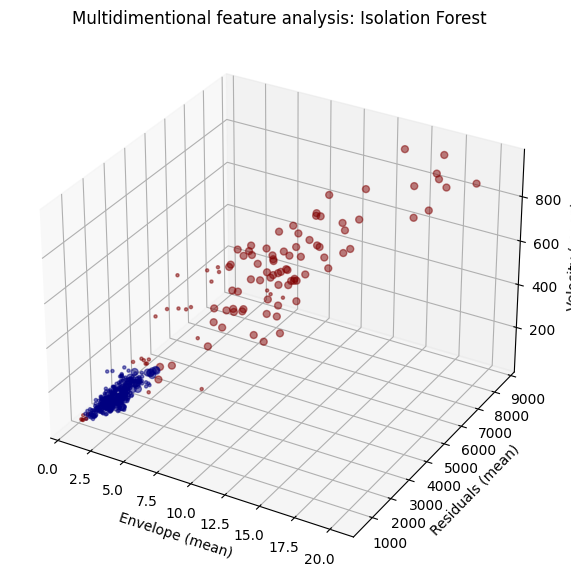

In [30]:
scatter_cluster_model = af.scatter_cluster("IsolationForest")
trained_model = scatter_cluster_model.fit(global_trajectory_feature, feature_list="all")
outliers_XY_RC = (scatter_cluster_model.predict(global_trajectory_feature, returnLabels=True) == -1).astype(int)


mwLength = 20
step = 5
seizure_label_sub = seizure_label[:-mwLength:step]

factor1 = 'v_env_mean'
factor2 = 'residual_mean'
factor3 = 'vtot_max'

x = np.asarray(global_trajectory_feature[factor1])
y = np.asarray(global_trajectory_feature[factor2])
z = np.asarray(global_trajectory_feature[factor3])

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

ax.scatter3D(x,y,z, c = outliers_XY_RC, s = seizure_label_sub*20 + np.ones_like(seizure_label_sub)*5, cmap = 'jet', alpha = 0.5)

ax.set_xlabel('Envelope (mean)')
ax.set_ylabel('Residuals (mean)')
ax.set_zlabel('Velocity (mean)')
ax.set_title('Multidimentional feature analysis: Isolation Forest')

plt.show()

## State detection

Finally, double thresholding can be applied to the data to detect state transitions. Here two types of detected anomalies correspond to seizure and spikes.

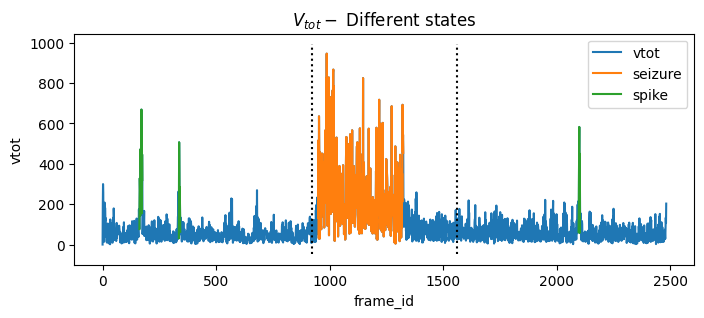

In [31]:
anom, bad = af.double_threshold(track.vtot, secondThreshold = 6000, returnNoise=True, maxSpacing=30, threshold=300)
fig, ax = ap.plot_features('frame_id','vtot',outliers=[anom, bad], outlierLabels=["seizure", "spike"], data=track, showPoints=False)

ylim=plt.ylim()
plt.plot([szStartSub,szStartSub], ylim, ':k')
plt.plot([szEndSub,szEndSub], ylim, ':k')
ax.set_title(r"$V_{tot} -$ Different states")
plt.show()